
# Imports

In [1]:
########################## EDA
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
#import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

C:\Users\Lenovo\anaconda3\envs\strive2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read data

In [2]:
df = pd.read_csv("imdb.csv")

df_train = df.sample(frac = 0.8)
  
df_valid = df.drop(df_train.index)

print("Number of documents in training data: %d" % len(df_train))
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data: 20000
Number of documents in validation data: 5000


# EDA
### Target

C:\Users\Lenovo\anaconda3\envs\strive2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

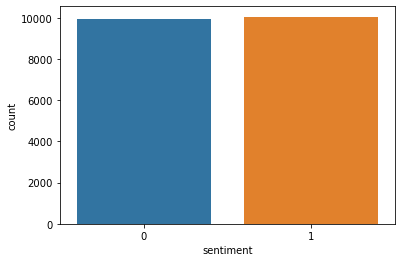

In [3]:
sb.countplot(df_train['sentiment'])

### Text

In [4]:
positive = df[df['sentiment']==0]['review']
negative = df[df['sentiment']==1]['review']

CPU times: total: 20.1 s
Wall time: 20.7 s


Text(0.5, 1.0, 'Negative')

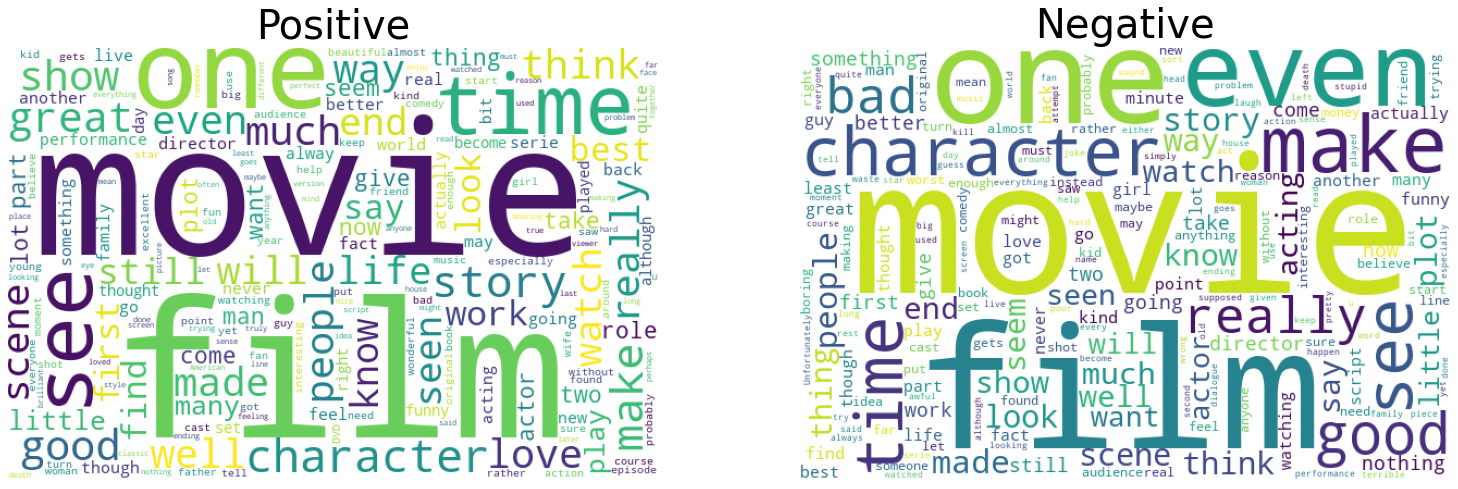

In [5]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [6]:
texts = [
    'Hello this is an sentence',
    'Hello this is another sentence',
    'Hello Hello Hello, this is mellow'
]

### Bag Of Words (BOW)

In [7]:
# create a CountVectorizer instance
# fit tranform the text with it
# get the features+

bow = CountVectorizer()
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names_out()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
Text 1,1,0,1,1,0,1,1
Text 2,0,1,1,1,0,1,1
Text 3,0,0,3,1,1,0,1


### Bag Of Words (BOW) + ngram

In [106]:
#do the same approach but using a range in the count vectorizer
bow = CountVectorizer(ngram_range=(1,3))
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names_out()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,an sentence,another,another sentence,hello,hello hello,hello hello hello,hello hello this,hello this,hello this is,...,is another,is another sentence,is mellow,mellow,sentence,this,this is,this is an,this is another,this is mellow
Text 1,1,1,0,0,1,0,0,0,1,1,...,0,0,0,0,1,1,1,1,0,0
Text 2,0,0,1,1,1,0,0,0,1,1,...,1,1,0,0,1,1,1,0,1,0
Text 3,0,0,0,0,3,2,1,1,1,1,...,0,0,1,1,0,1,1,0,0,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [11]:
#Same approach for the TfidfVectorizer
tfidf = TfidfVectorizer()
texts_tfidf = tfidf.fit_transform(texts)
tokens = tfidf.get_feature_names_out()
pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
Text 1,0.617227,0.000000,0.364544,0.364544,0.000000,0.469417,0.364544
Text 2,0.000000,0.617227,0.364544,0.364544,0.000000,0.469417,0.364544
Text 3,0.000000,0.000000,0.805627,0.268542,0.454682,0.000000,0.268542


# <center> Apply to the reviews

### Bag Of Words 1-gram

In [51]:
import numpy as np

In [56]:
train_text = df_train['review']
valid_text = df_valid['review']
y_train = df_train['sentiment']
y_valid = df_valid['sentiment']
y_train = np.array(y_train).reshape(-1)
y_valid = np.array(y_valid).reshape(-1)



In [57]:
%%time
bow_1gram = CountVectorizer() # default ngram_range is (1,1)

train_bow_1gram = bow_1gram.fit_transform(train_text)
valid_bow_1gram = bow_1gram.transform(valid_text)

CPU times: total: 4.81 s
Wall time: 4.82 s


### Bag Of Words 1-2-grams

In [46]:
%%time
bow_2grams = CountVectorizer(ngram_range=(1, 2))
train_bow_2grams = bow_2grams.fit_transform(train_text)
valid_bow_2grams = bow_2grams.transform(valid_text)

CPU times: total: 16.5 s
Wall time: 16.6 s


### TFIDF 1-gram

In [47]:
%%time
tfidf_1gram       = TfidfVectorizer()
train_tfidf_1gram = tfidf_1gram.fit_transform(train_text)
valid_tfidf_1gram = tfidf_1gram.transform(valid_text)

CPU times: total: 5.14 s
Wall time: 5.15 s


### TFIDF 1-2-grams

In [38]:
%%time
tfidf_2grams      = TfidfVectorizer(ngram_range=(1, 2))
train_tfidf_2grams = tfidf_2grams.fit_transform(train_text)
valid_tfidf_2grams = tfidf_2grams.transform(valid_text)

CPU times: total: 18.5 s
Wall time: 18.6 s


In [48]:
data = [
    ("BOW 1gram",   train_bow_1gram, valid_bow_1gram),
    ("BOW 2grams",  train_bow_2grams, valid_bow_2grams),
    ("TFIDF 1gram", train_tfidf_1gram, valid_tfidf_1gram),
    ("TFIDF 2grams",train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (20000, 68688)
BOW 2grams   (20000, 1299802)
TFIDF 1gram  (20000, 68688)
TFIDF 2grams (20000, 1299802)


# <center> ML Models

## Naive Bayes (<1 s)

In [40]:
model_naive = MultinomialNB()

In [58]:
for name, x_train, x_valid in data:
    start_time = time.time()
    #Train a MultinomialNB model and meassure the time
    model_naive.fit(x_train, y_train)
    a = accuracy_score(y_valid, model_naive.predict(x_valid))
    t = time.time() - start_time
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8416 	Time:	 0.06668305397033691
BOW 2grams 	Accuracy:	 0.8778 	Time:	 0.2892272472381592
TFIDF 1gram 	Accuracy:	 0.8584 	Time:	 0.03892707824707031
TFIDF 2grams 	Accuracy:	 0.8808 	Time:	 0.23936152458190918


## Logistic Regression (30s)

In [107]:
model_log = LogisticRegression(max_iter=1000)

In [108]:
for name, x_train, x_valid in data:
    #Train a LogisticRegression model and meassure the time
    start_time = time.time()
    model_log.fit(x_train, y_train)
    a = accuracy_score(y_valid, model_log.predict(x_valid))
    t = time.time() - start_time
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.883 	Time:	 24.491689443588257
BOW 2grams 	Accuracy:	 0.8978 	Time:	 204.5898072719574
TFIDF 1gram 	Accuracy:	 0.885 	Time:	 1.9555659294128418
TFIDF 2grams 	Accuracy:	 0.8842 	Time:	 34.513010025024414


## Random Forest (10+90+6+22 seconds)

In [64]:
model_for = RandomForestClassifier()

In [65]:
for name, x_train, x_valid in data:
    #Train a RandomForestClassifier model and meassure the time
    start_time = time.time()
    model_for.fit(x_train, y_train)
    a = accuracy_score(y_valid, model_for.predict(x_valid))
    t = time.time() - start_time
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8394 	Time:	 55.899484157562256
BOW 2grams 	Accuracy:	 0.855 	Time:	 233.40107560157776
TFIDF 1gram 	Accuracy:	 0.833 	Time:	 43.01189661026001
TFIDF 2grams 	Accuracy:	 0.8492 	Time:	 234.45890402793884


In [113]:
input_data = ["I realized a couple of days ago that the makers of this film put a play on words into its title. This movie is not primarily about the act of riding giants, but mostly about the people who are the giants of the sport, RIDING giants, to change the emphasis.  In my teens I lived a block from the Wedge, one of the hardest-breaking and best bodysurfing spots in the world. I have been out in 15-to-18 foot surf, and have ridden and been hammered by 10 and 12-foot waves on many occasions. That experience is why I am in complete awe of the surfers in this film. The idea that Jeff Clark, to all appearances a normal mortal, could get away with riding Maverick is BY HIMSELF for over a decade is beyond my grasp. The first safety rule of any water sport is Never surf/dive/swim by yourself. He went where sane people would not, and lived to tell about it. I would npt go out there if the water were 75 degrees and the sharks all left.   In the world of warm water: the first shot of the waves at Jaws always makes the skin tingle over my entire body. These are not just scary waves, these are uncontrolled-bowel-evacuation waves. When we see Laird Hamilton not only surviving 40-to-60 foot waves (I can hardly type those numbers), but actually working the faces like a fun day at Rincon, I am blown away. There is a dedication and focus in big-wave riders which is comparable to that of anyone in the world.   This a great film. I gave it a 9 instead of a 10 only because it neglects to mention that there are great big-wave riders in the world outside the Hamilton/Kalama crew, and I think they deserved mention. Splice in Ken Bradshaw at outside Log Cabins and a 10 it is!",
"This seems to be a terrible movie. It has great scenes and lovely actors though", 
"I have watched the movie 10 times and did not find it to be bad. All actors played well.", 
"I love this movie. It has been one of the best movies of the year.", 
"It is one of the better Indian movies I have seen lately, instead of crappy song and dance or slum dog movies. All the actors have showed the right emotions at the right intensity with right timing. It is the hallmark of a good movie, that it make the viewer go back and research the subject, which exactly what I did checking on Harilal. I always enjoy Akshay Khanna's subtle style of acting and interestingly he had rather a complicated relationship with his own father Vinod Khanna, albeit not as dramatic as Gandhis and wonder how it helped him essay this character. I was impressed by the direction and 2 thumbs up for Anil Kapoor for producing such a classy movie.",
"I have to admit I raised an eyebrow when I saw that Barry Keoghan was rumors to be cast for the joker, and after I saw eternals I thought his joker would be rather strange. Honestly I found the deleted scene interesting, however I felt like it was just an imitation of Heath Ledgers Joker. I do see why it was deleted. Keoghans Scene in the actual Batman movie when he talks to the riddler in Arkham was probably better than this and I did really enjoy the joker tease. I think keoghan should be in the Batman 3 because if he appeared in the second movie he would be constantly compared to ledger. A solid scene altogether though.",
"Another amazing addition to the Star Wars franchise with wonderful story arcs and wonderful standalone episodes. It goes to places you would never think of, and once you start watching it, the next thing you know your still on the couch five hours later wanting to see what's next"]

In [114]:
input_data = tfidf_2grams.transform(input_data)

In [115]:
pred = model_naive.predict(input_data)

In [116]:
for i in pred:
    if pred[i] == 0:
        print('This is a good review')
    else:
        print('This is a negative review')

This is a good review
This is a negative review
This is a negative review
This is a good review
This is a good review
This is a negative review
This is a good review
